In [74]:
import os
import re as re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [75]:
y_min, y_max = 1403, 1914
x_min, x_max = 66, 577

geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons = geodata["lon"][y_min:y_max+1, x_min:x_max+1]
lats = geodata["lat"][y_min:y_max+1, x_min:x_max+1]

In [76]:
lead_times = [1, 3, 6]

In [77]:
auc_dir = "/work/scratch-nopw2/mendrika/OB/evaluation/ncast-nflics/auc"

In [78]:
hours = [f"{h:02d}" for h in range(24)]

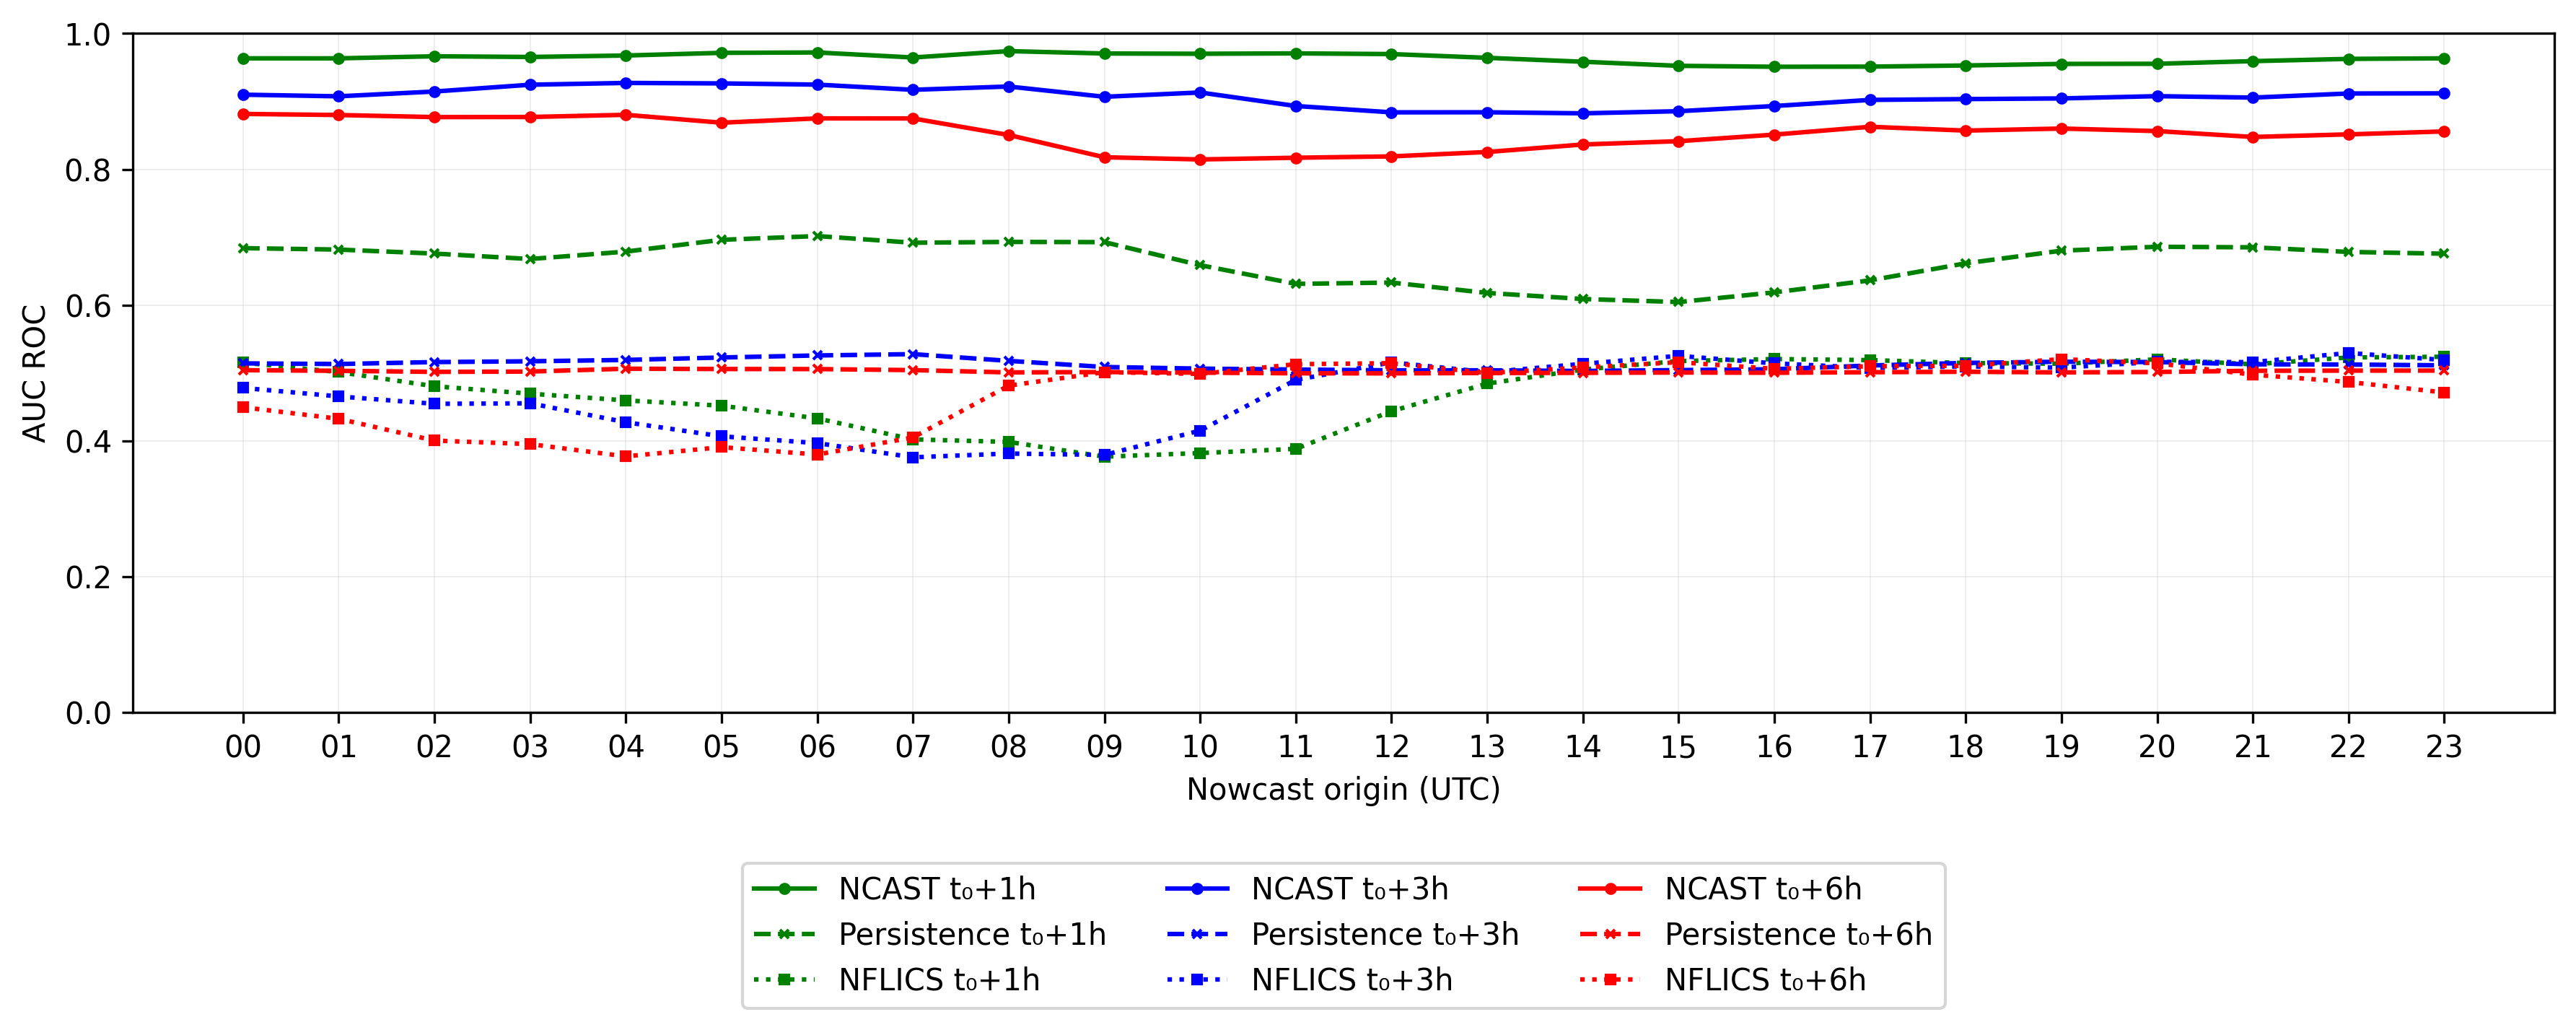

In [79]:
# colours to match previous plots
colours = {
    "1": "green",
    "3": "blue",
    "6": "red",
}

auc_model = {L: [] for L in lead_times}
auc_pers  = {L: [] for L in lead_times}
auc_nflics = {L: [] for L in lead_times}

for L in lead_times:
    for h in hours:
        m_path = os.path.join(auc_dir, f"auc_model_hour_{h}_t{L}.npy")
        p_path = os.path.join(auc_dir, f"auc_persistence_hour_{h}_t{L}.npy")
        n_path = os.path.join(auc_dir, f"auc_nflics_hour_{h}_t{L}.npy")

        if os.path.exists(m_path):
            auc_model[L].append(float(np.load(m_path)))
            auc_pers[L].append(float(np.load(p_path)))
            auc_nflics[L].append(float(np.load(n_path)))
        else:
            auc_model[L].append(np.nan)
            auc_pers[L].append(np.nan)
            auc_nflics[L].append(np.nan)

plt.figure(figsize=(12,5), dpi=300)

for L in lead_times:
    c = colours[f"{L}"]

    # model (solid)
    plt.plot(
        hours,
        auc_model[L],
        marker="o",
        markersize=3,
        linestyle="-",
        color=c,
        label=f"NCAST t₀+{L}h",
    )

    # persistence (dashed)
    plt.plot(
        hours,
        auc_pers[L],
        marker="x",
        markersize=3,
        linestyle="--",
        color=c,
        label=f"Persistence t₀+{L}h",
    )

    # NFLICS (dotted)
    plt.plot(
        hours,
        auc_nflics[L],
        marker="s",
        markersize=3,
        linestyle=":",
        color=c,
        label=f"NFLICS t₀+{L}h",
    )

plt.xlabel("Nowcast origin (UTC)")
plt.ylabel("AUC ROC")
plt.ylim(0, 1)
plt.grid(True, linewidth=0.1)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=3
)

plt.tight_layout()
plt.show()

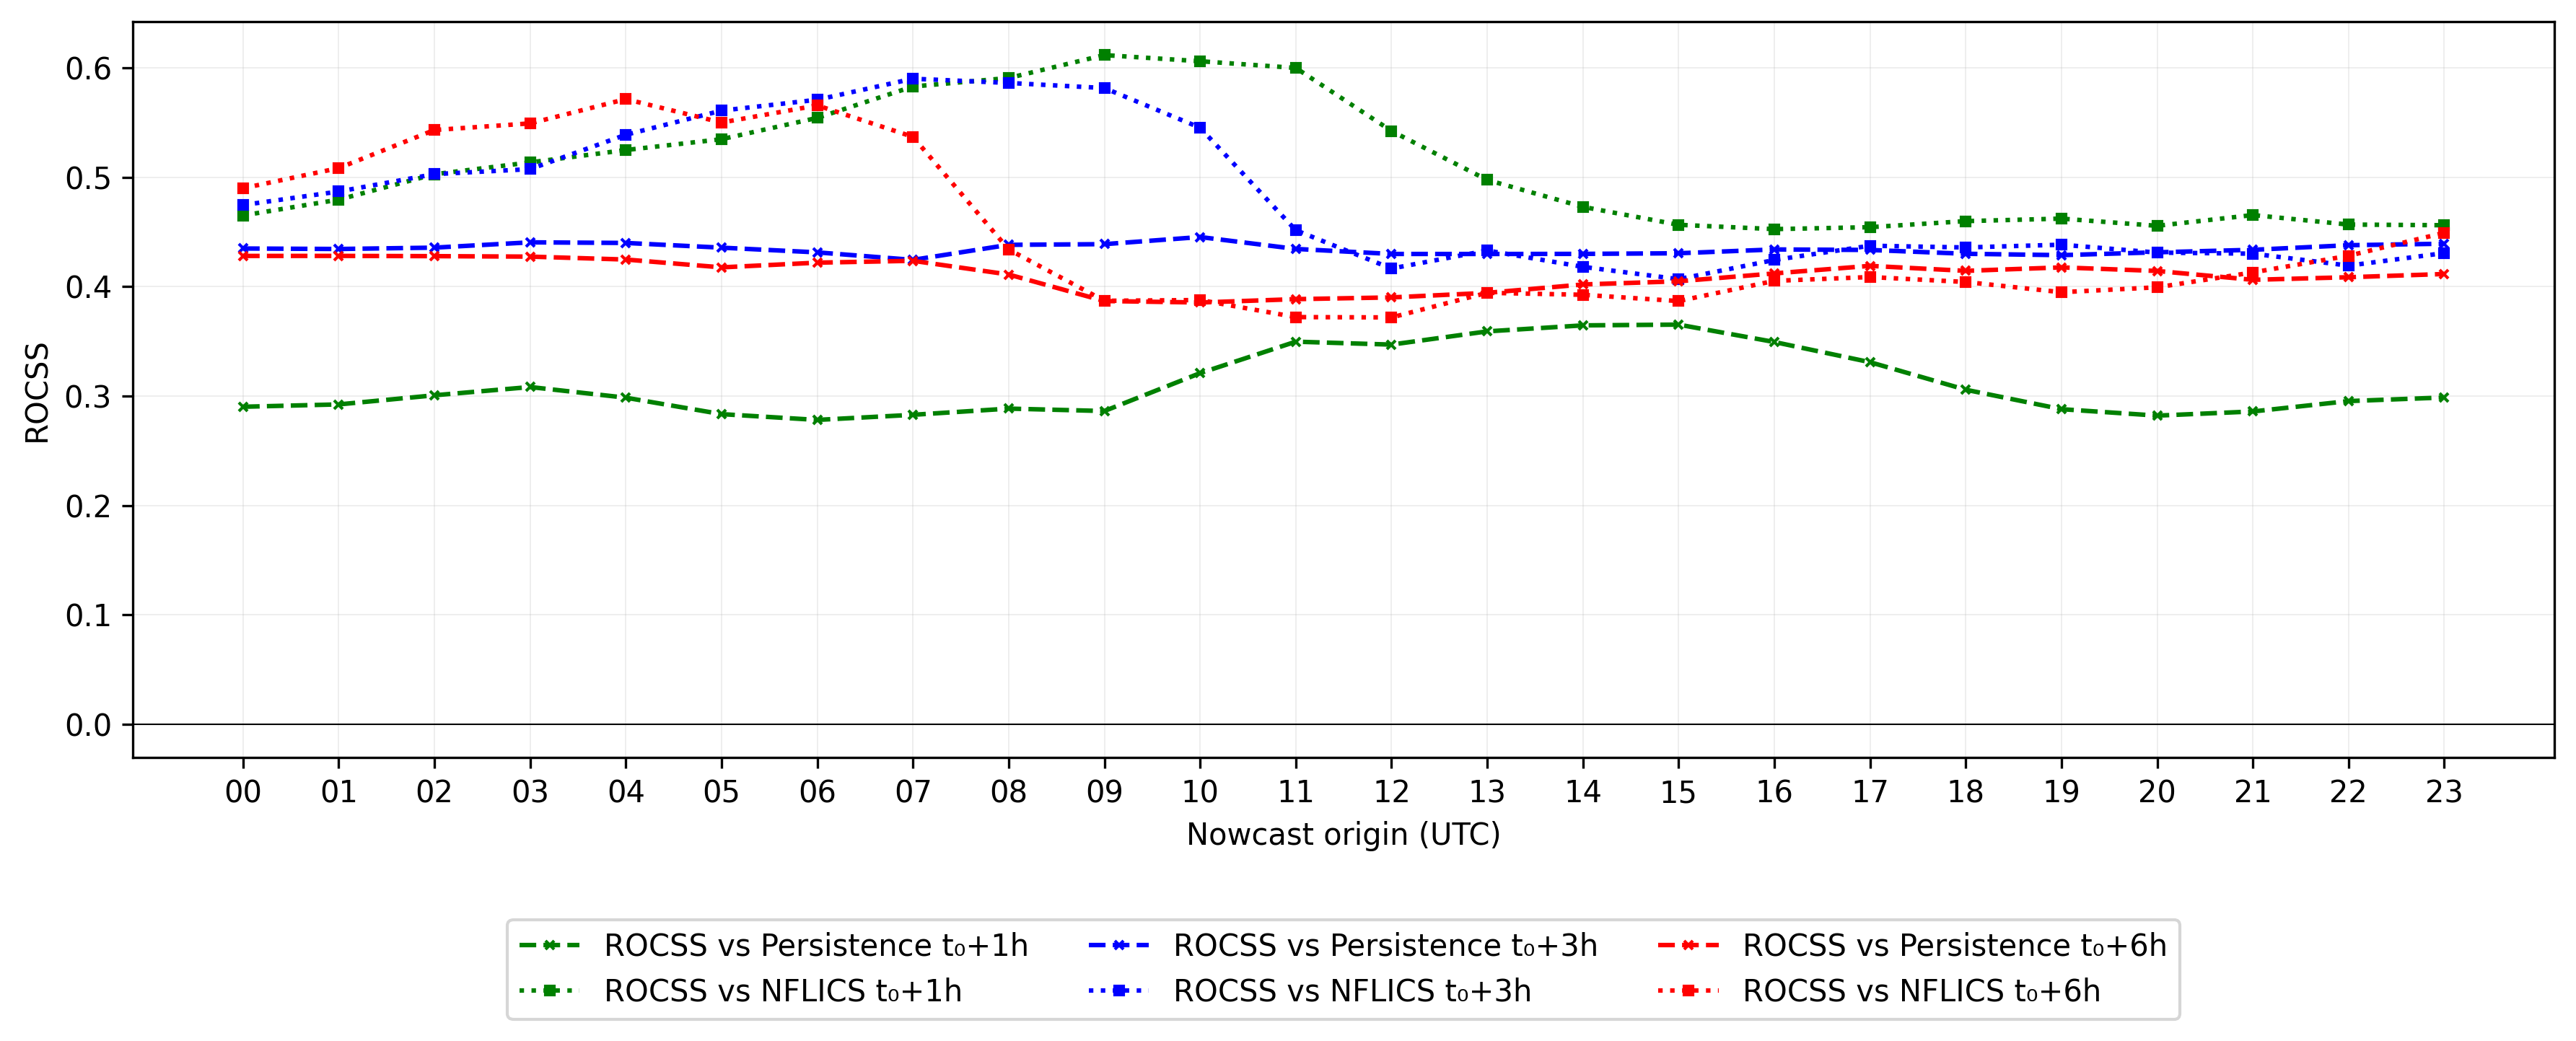

In [80]:
# colours to match previous plots
colours = {
    "1": "green",
    "3": "blue",
    "6": "red",
}

auc_model  = {L: [] for L in lead_times}
auc_pers   = {L: [] for L in lead_times}
auc_nflics = {L: [] for L in lead_times}

for L in lead_times:
    for h in hours:
        m_path = os.path.join(auc_dir, f"auc_model_hour_{h}_t{L}.npy")
        p_path = os.path.join(auc_dir, f"auc_persistence_hour_{h}_t{L}.npy")
        n_path = os.path.join(auc_dir, f"auc_nflics_hour_{h}_t{L}.npy")

        if os.path.exists(m_path):
            auc_model[L].append(float(np.load(m_path)))
            auc_pers[L].append(float(np.load(p_path)))
            auc_nflics[L].append(float(np.load(n_path)))
        else:
            auc_model[L].append(np.nan)
            auc_pers[L].append(np.nan)
            auc_nflics[L].append(np.nan)


# -------------------------------
# Compute ROCSS relative to model
# -------------------------------
rocss_pers   = {L: [] for L in lead_times}
rocss_nflics = {L: [] for L in lead_times}

for L in lead_times:
    for am, ap, an in zip(auc_model[L], auc_pers[L], auc_nflics[L]):
        
        if np.isnan(am) or am == 0:
            rocss_pers[L].append(np.nan)
            rocss_nflics[L].append(np.nan)
            continue
        
        # ROC Skill Score: 1 - (AUC_ref / AUC_model)
        rocss_p = 1 - ap / am if not np.isnan(ap) else np.nan
        rocss_n = 1 - an / am if not np.isnan(an) else np.nan

        rocss_pers[L].append(rocss_p)
        rocss_nflics[L].append(rocss_n)


plt.figure(figsize=(12,5), dpi=300)

for L in lead_times:
    c = colours[f"{L}"]
    label_suffix = f"t₀+{L}h"

    # ROCSS vs persistence
    plt.plot(
        hours,
        rocss_pers[L],
        marker="x",
        markersize=3,
        linestyle="--",
        color=c,
        label=f"ROCSS vs Persistence {label_suffix}",
    )

    # ROCSS vs NFLICS
    plt.plot(
        hours,
        rocss_nflics[L],
        marker="s",
        markersize=3,
        linestyle=":",
        color=c,
        label=f"ROCSS vs NFLICS {label_suffix}",
    )

plt.axhline(0, color="black", linewidth=0.5)

plt.xlabel("Nowcast origin (UTC)")
plt.ylabel("ROCSS")
plt.grid(True, linewidth=0.1)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=3
)

plt.tight_layout()
plt.show()

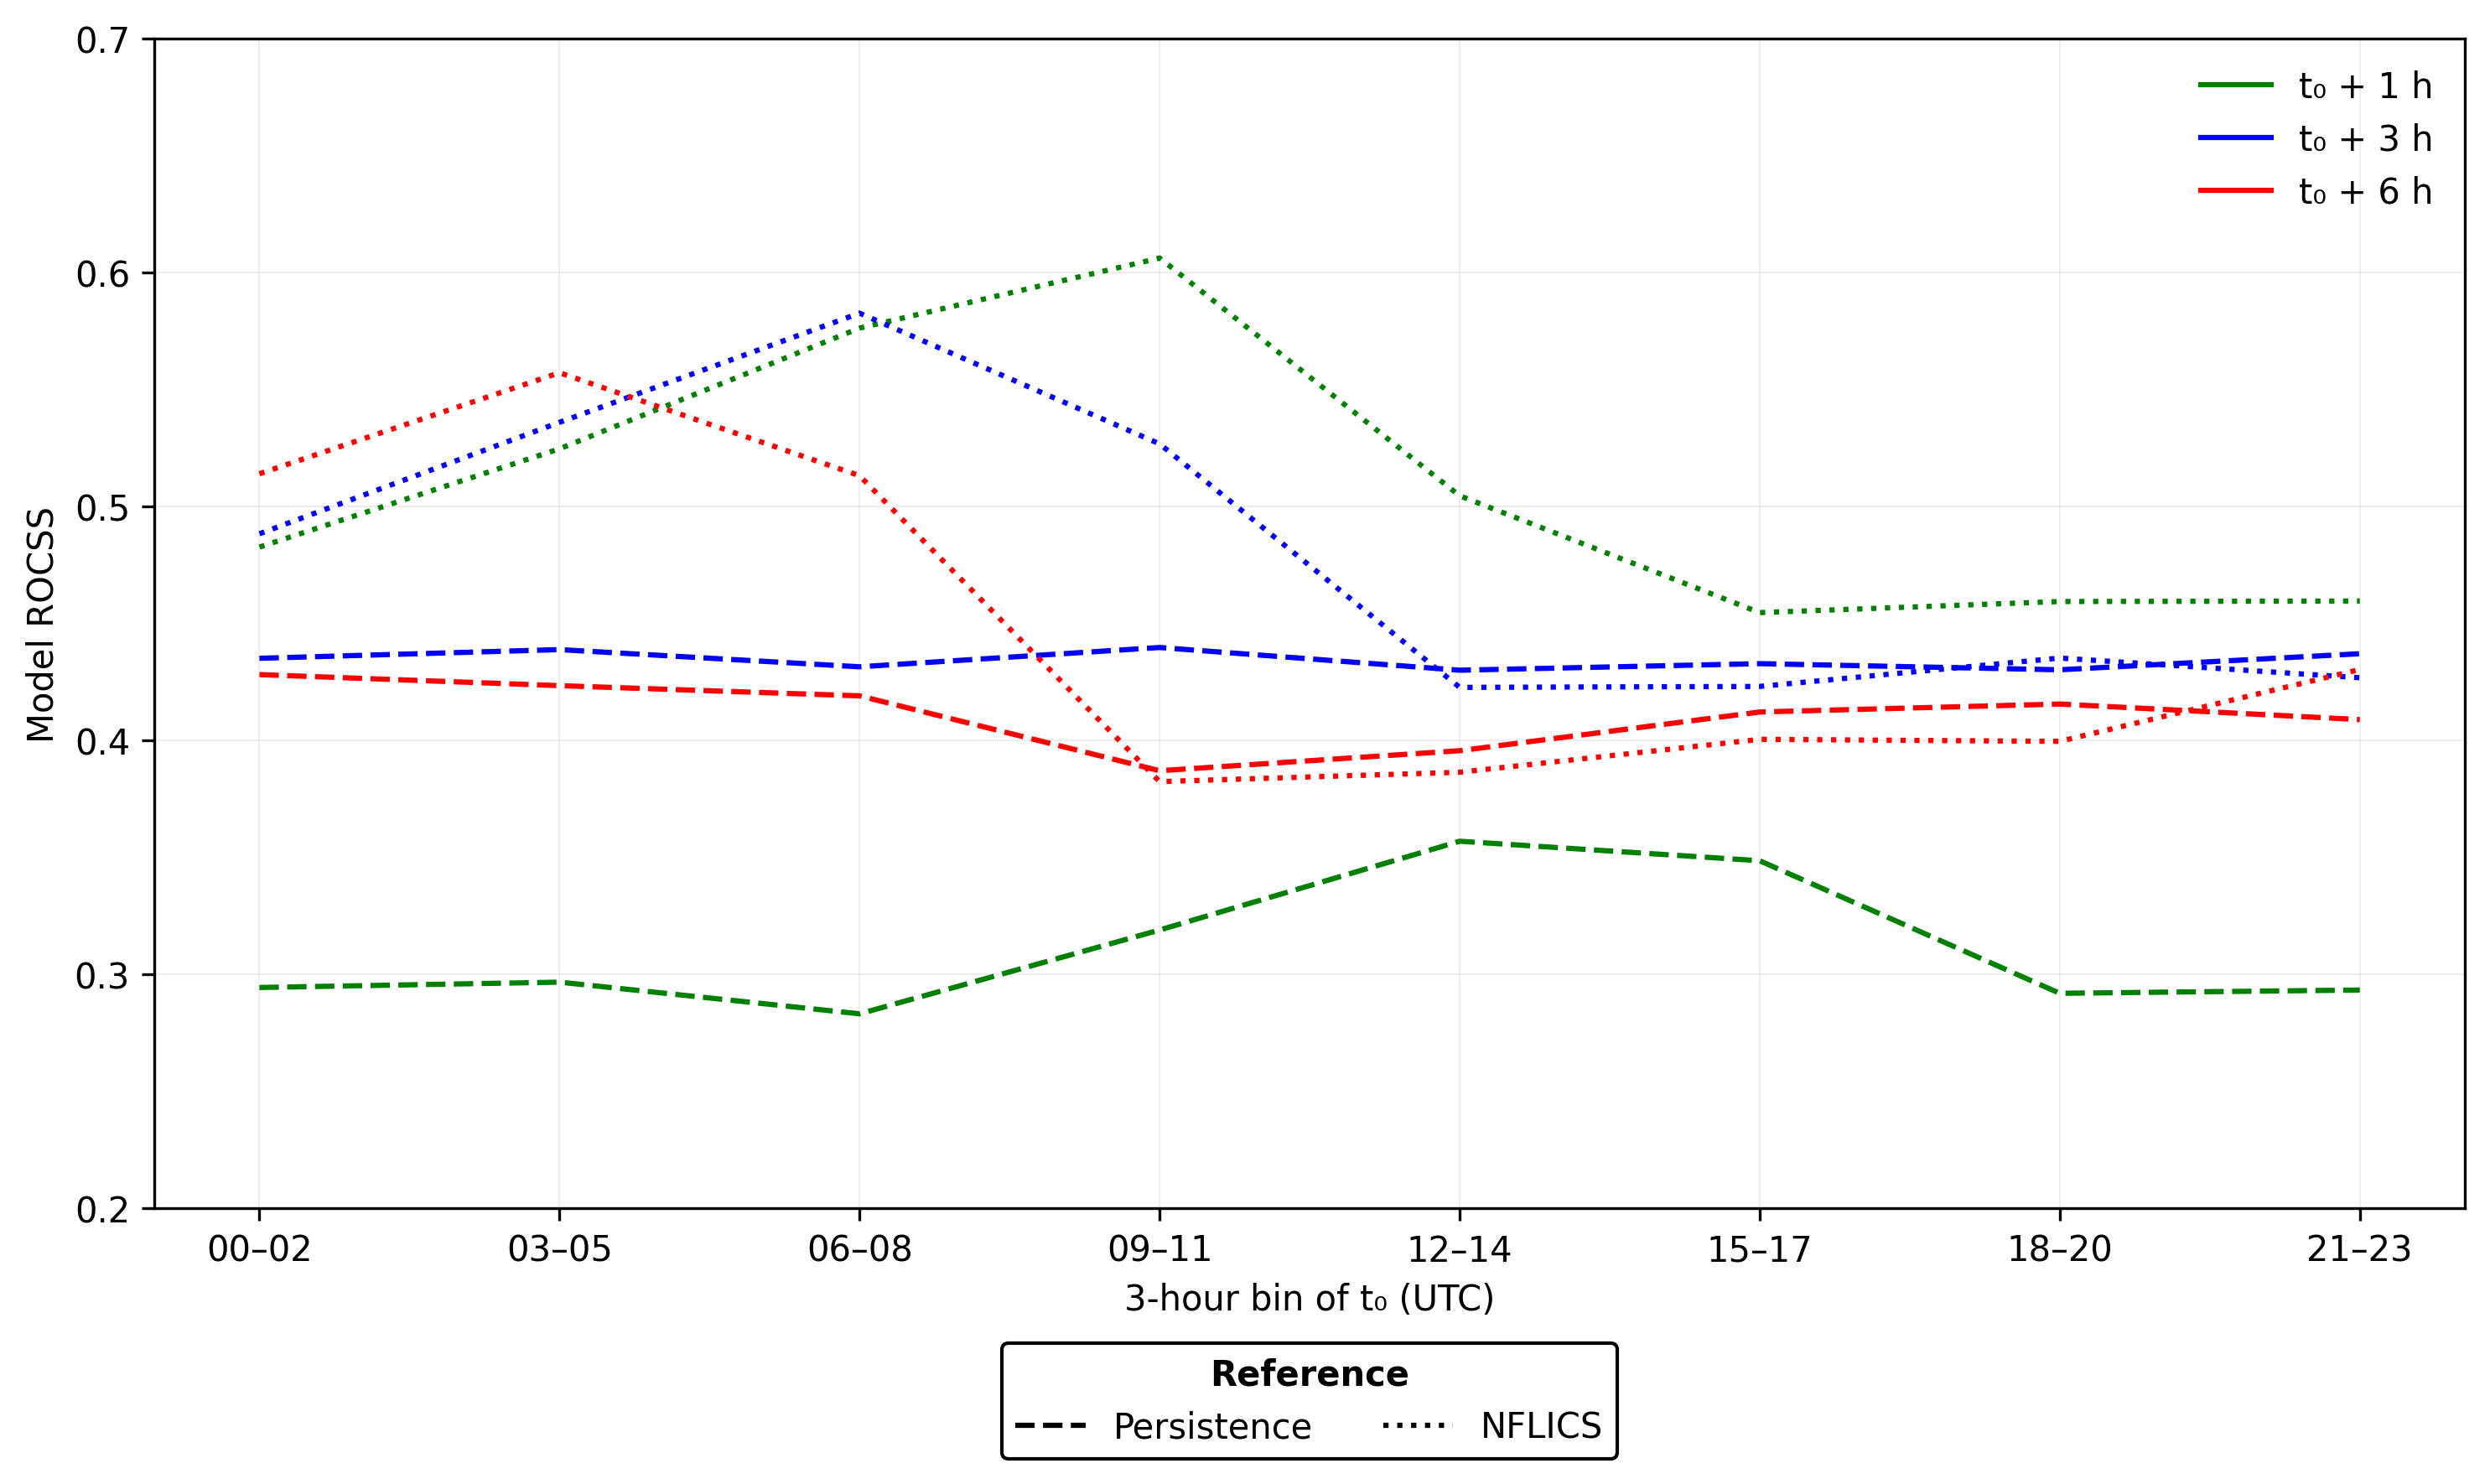

In [108]:

bins = {
    "00–02": ["00", "01", "02"],
    "03–05": ["03", "04", "05"],
    "06–08": ["06", "07", "08"],
    "09–11": ["09", "10", "11"],
    "12–14": ["12", "13", "14"],
    "15–17": ["15", "16", "17"],
    "18–20": ["18", "19", "20"],
    "21–23": ["21", "22", "23"],
}

bin_labels = list(bins.keys())

nflics_linestyle = ":"

# colour per lead time
colours = {
    "1": "green",
    "3": "blue",
    "6": "red",
}

def load_auc(hour, lead):
    m_path = os.path.join(auc_dir, f"auc_model_hour_{hour}_t{lead}.npy")
    p_path = os.path.join(auc_dir, f"auc_persistence_hour_{hour}_t{lead}.npy")
    n_path = os.path.join(auc_dir, f"auc_nflics_hour_{hour}_t{lead}.npy")

    if os.path.exists(m_path) and os.path.exists(p_path) and os.path.exists(n_path):
        return float(np.load(m_path)), float(np.load(p_path)), float(np.load(n_path))
    return np.nan, np.nan, np.nan

auc_model_binned  = {L: [] for L in lead_times}
auc_pers_binned   = {L: [] for L in lead_times}
auc_nflics_binned = {L: [] for L in lead_times}

for L in lead_times:
    for label in bin_labels:
        hours = bins[label]

        vals_m, vals_p, vals_n = [], [], []
        for h in hours:
            am, ap, an = load_auc(h, L)
            vals_m.append(am)
            vals_p.append(ap)
            vals_n.append(an)

        auc_model_binned[L].append(np.nanmean(vals_m))
        auc_pers_binned[L].append(np.nanmean(vals_p))
        auc_nflics_binned[L].append(np.nanmean(vals_n))

rocss_pers_binned   = {L: [] for L in lead_times}
rocss_nflics_binned = {L: [] for L in lead_times}

for L in lead_times:
    for am, ap, an in zip(
        auc_model_binned[L],
        auc_pers_binned[L],
        auc_nflics_binned[L],
    ):
        if np.isnan(am) or am == 0:
            rocss_pers_binned[L].append(np.nan)
            rocss_nflics_binned[L].append(np.nan)
            continue

        r_p = 1 - ap / am if not np.isnan(ap) else np.nan
        r_n = 1 - an / am if not np.isnan(an) else np.nan

        rocss_pers_binned[L].append(r_p)
        rocss_nflics_binned[L].append(r_n)

plt.figure(figsize=(10, 6), dpi=300)

for L in lead_times:
    c = colours[L]

    # ROCSS vs Persistence
    plt.plot(
        bin_labels,
        rocss_pers_binned[L],
        linestyle="--",
        color=c,
    )

    # ROCSS vs NFLICS
    plt.plot(
        bin_labels,
        rocss_nflics_binned[L],
        linestyle=nflics_linestyle,
        color=c,
    )

plt.axhline(0, color="black", linewidth=0.5)

plt.xlabel("3-hour bin of t₀ (UTC)")
plt.ylabel("Model ROCSS")
plt.grid(True, linewidth=0.1)
plt.ylim(0.2, 0.7)

colour_handles = [
    Line2D([0], [0], color="green", linestyle="-", label="t₀ + 1 h"),
    Line2D([0], [0], color="blue",  linestyle="-", label="t₀ + 3 h"),
    Line2D([0], [0], color="red",   linestyle="-", label="t₀ + 6 h"),
]

first_legend = plt.legend(
    handles=colour_handles,
    loc="upper right",
    frameon=False,
)
plt.gca().add_artist(first_legend)

style_handles = [
    Line2D([0], [0], color="black", linestyle="--", label="Persistence"),
    Line2D([0], [0], color="black", linestyle=":",  label="NFLICS"),
]

leg = plt.legend(
    handles=style_handles,
    title="Reference",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    frameon=True,
    framealpha=1.0,
    edgecolor="black",
)

leg.get_title().set_fontweight("bold")

plt.tight_layout()
plt.show()

# BSS

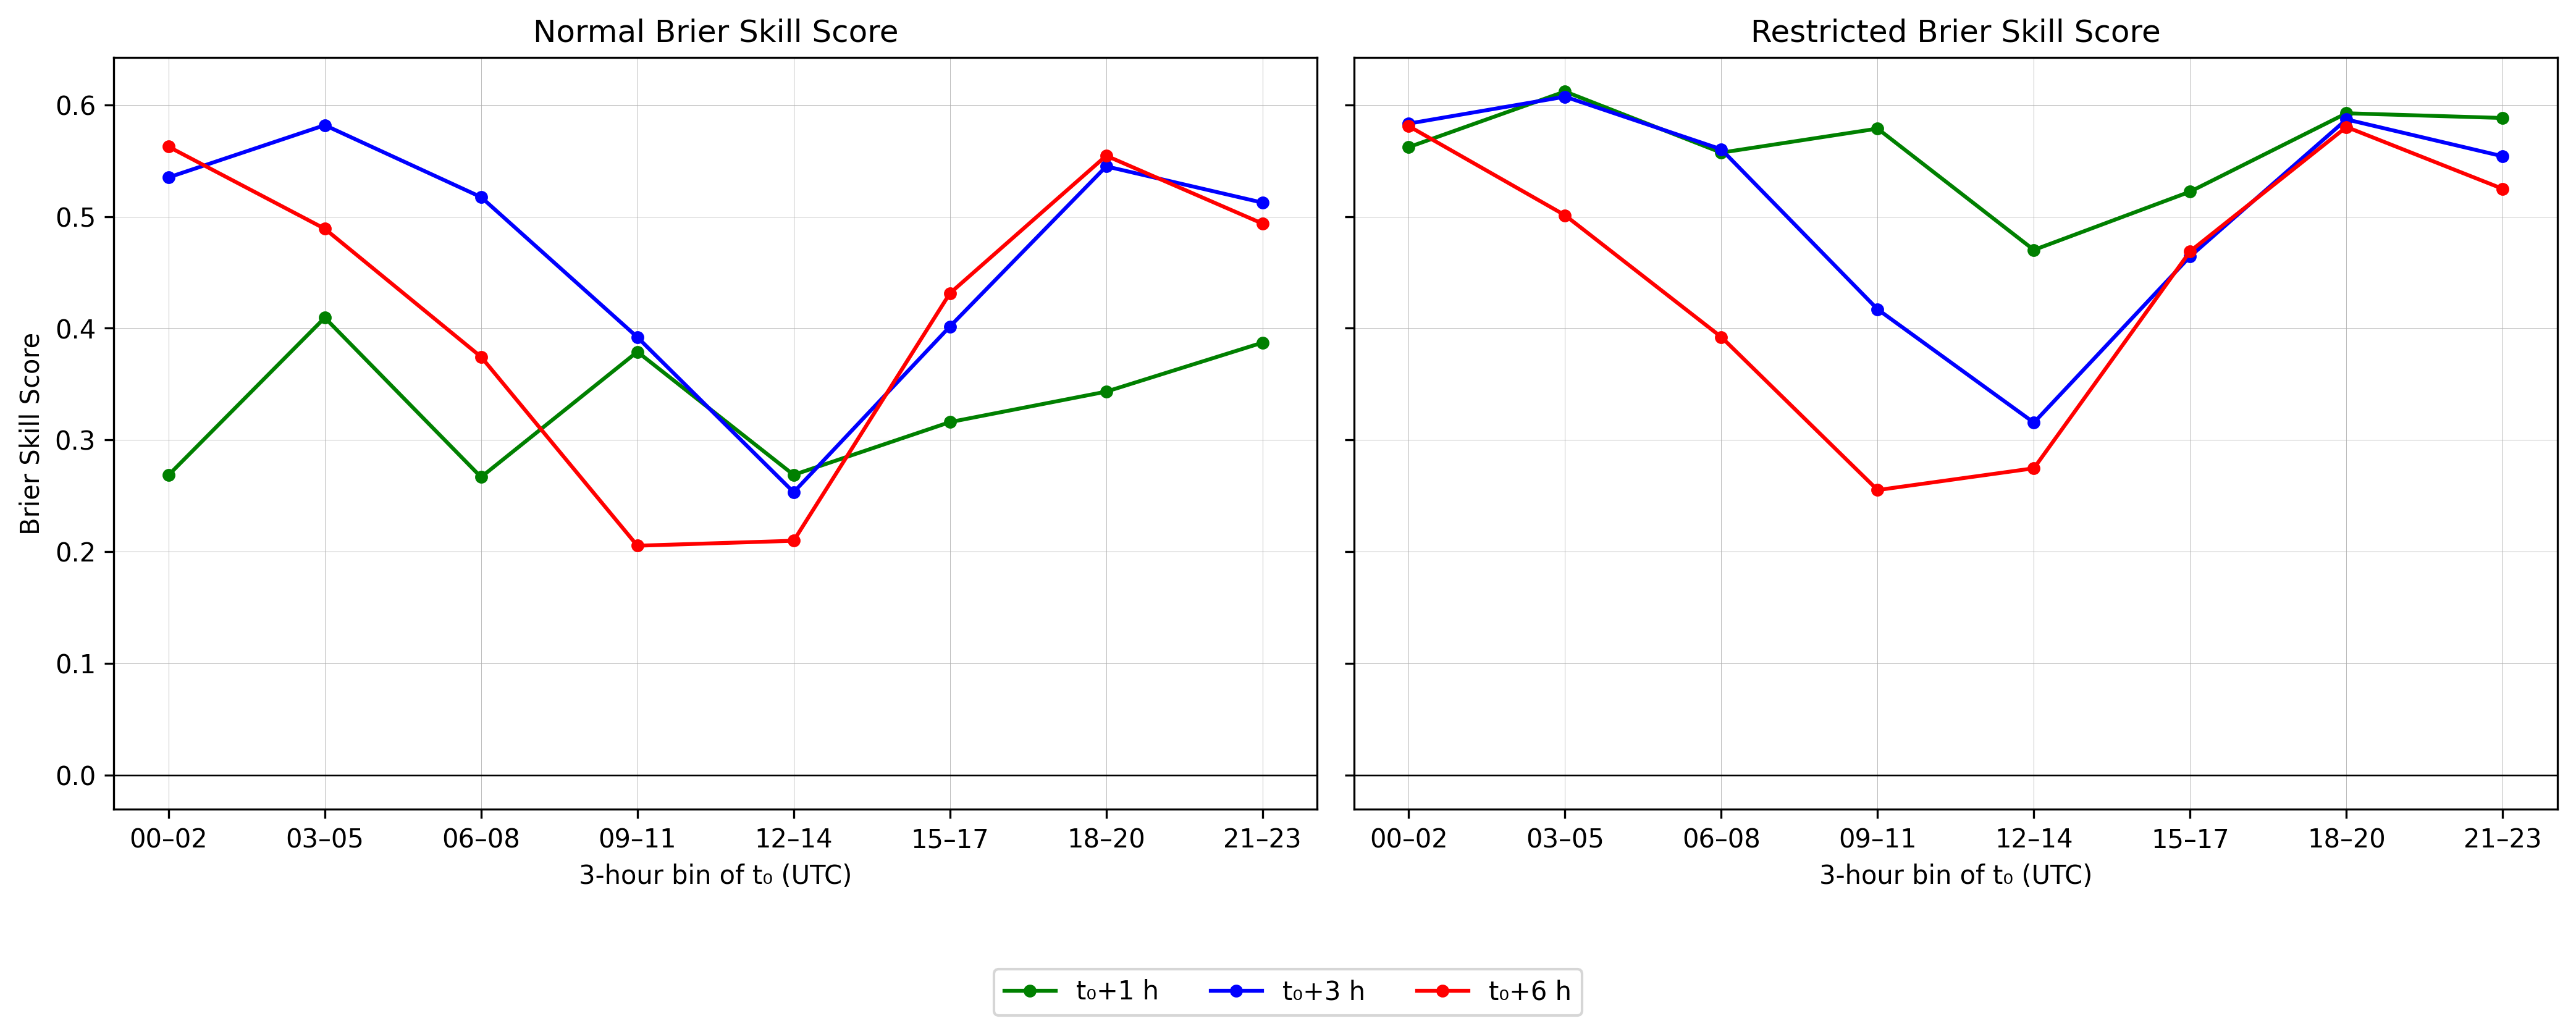

In [109]:
# hour bins
bins = {
    "00–02": ["00", "01", "02"],
    "03–05": ["03", "04", "05"],
    "06–08": ["06", "07", "08"],
    "09–11": ["09", "10", "11"],
    "12–14": ["12", "13", "14"],
    "15–17": ["15", "16", "17"],
    "18–20": ["18", "19", "20"],
    "21–23": ["21", "22", "23"],
}

bin_labels = list(bins.keys())

bss_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/ncast-calibrated/bss"

colours = {
    "1": "green",
    "3": "blue",
    "6": "red",
}

# storage
normal = {L: {b: [] for b in bin_labels} for L in lead_times}
restricted = {L: {b: [] for b in bin_labels} for L in lead_times}

# load BSS values into bins
for L in lead_times:
    for b, hours_list in bins.items():
        for h in hours_list:

            # normal BSS path
            n_path = os.path.join(
                bss_dir, f"bss_normal_model_hour_{h}_t{L}.npy"
            )
            if os.path.exists(n_path):
                normal[L][b].append(float(np.load(n_path)))

            # restricted BSS path
            r_path = os.path.join(
                bss_dir, f"bss_restricted_model_hour_{h}_t{L}.npy"
            )
            if os.path.exists(r_path):
                restricted[L][b].append(float(np.load(r_path)))

# compute bin means
normal_mean = {
    L: [np.nanmean(normal[L][b]) for b in bin_labels]
    for L in lead_times
}

restricted_mean = {
    L: [np.nanmean(restricted[L][b]) for b in bin_labels]
    for L in lead_times
}

# plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=300, sharey=True)

# --- panel 1: normal BSS ---
ax = axes[0]
for L in lead_times:
    ax.plot(
        bin_labels,
        normal_mean[L],
        marker="o",
        markersize=4,
        linestyle="-",
        color=colours[L],
        label=f"t₀+{L} h",
    )

ax.axhline(0, color="black", linewidth=0.6)
ax.set_title("Normal Brier Skill Score")
ax.set_xlabel("3-hour bin of t₀ (UTC)")
ax.set_ylabel("Brier Skill Score")
ax.grid(True, linewidth=0.2)

# --- panel 2: restricted BSS ---
ax = axes[1]
for L in lead_times:
    ax.plot(
        bin_labels,
        restricted_mean[L],
        marker="o",
        markersize=4,
        linestyle="-",
        color=colours[L],
        label=f"t₀+{L} h",
    )

ax.axhline(0, color="black", linewidth=0.6)
ax.set_title("Restricted Brier Skill Score")
plt.xlabel("3-hour bin of t₀ (UTC)")
ax.grid(True, linewidth=0.2)

# shared legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=3,
)

plt.tight_layout()
plt.show()


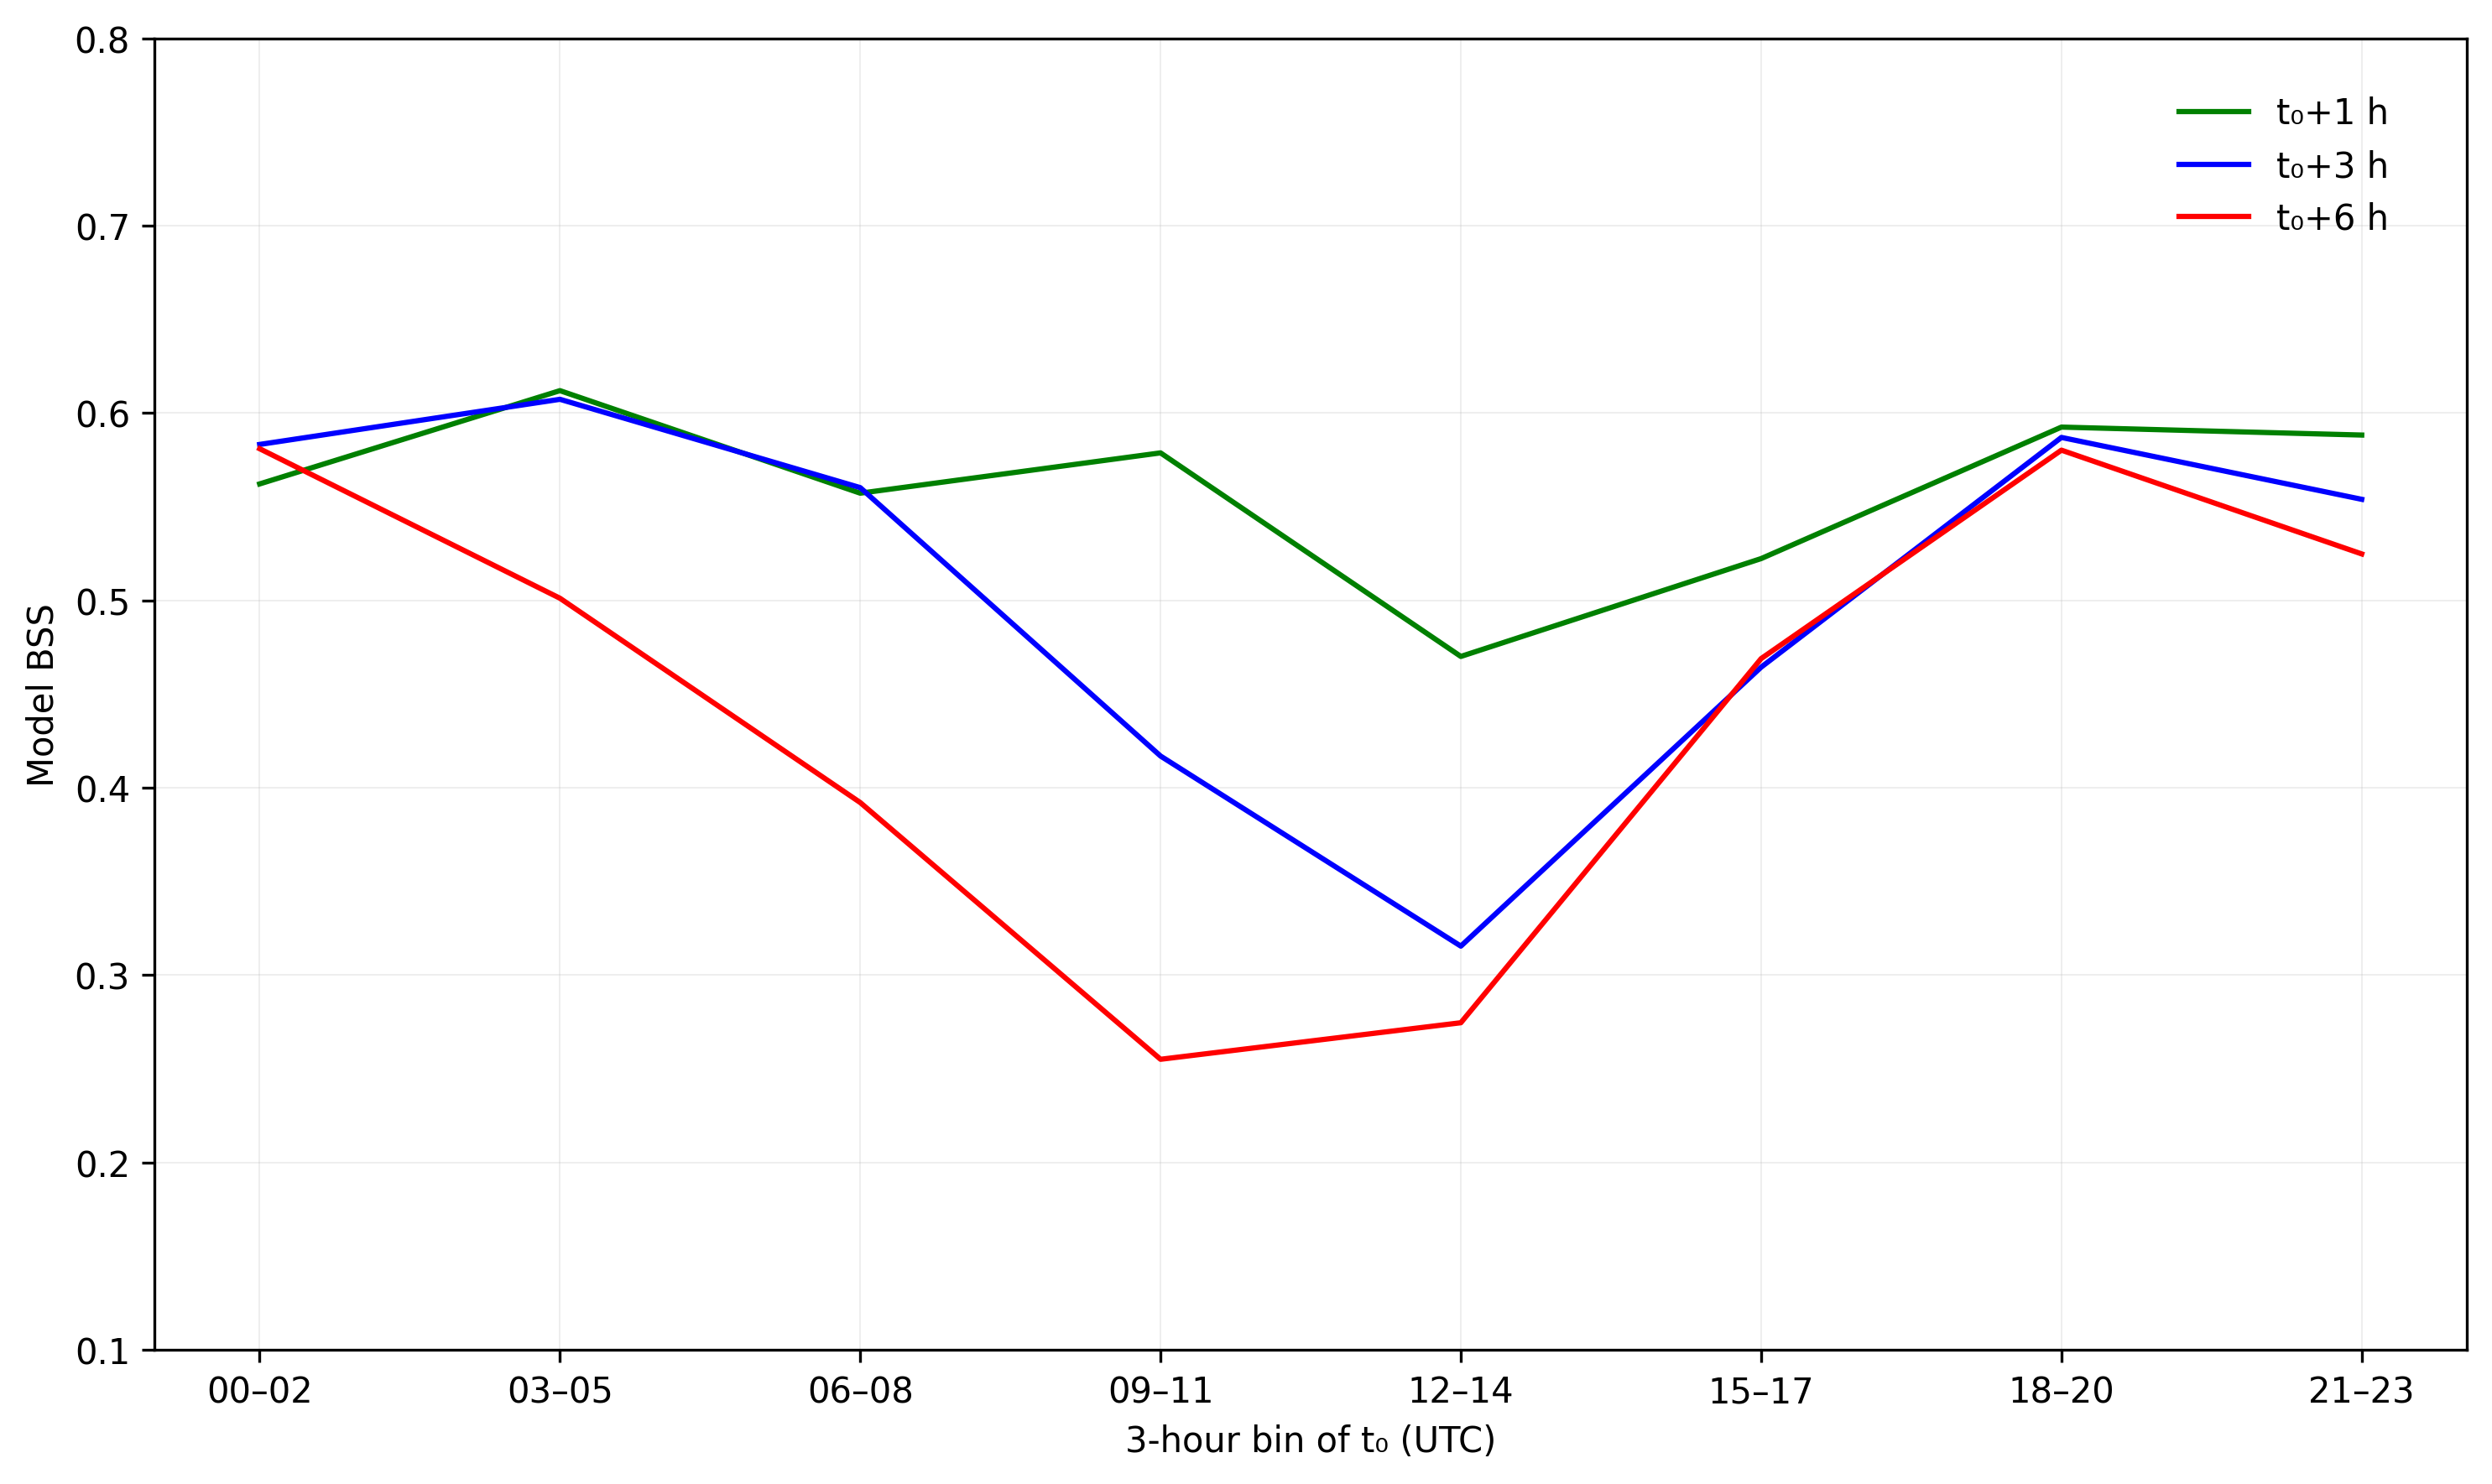

In [122]:
restricted = {L: {b: [] for b in bin_labels} for L in lead_times}

for L in lead_times:
    for b, hours_list in bins.items():
        for h in hours_list:
            r_path = os.path.join(
                bss_dir, f"bss_restricted_model_hour_{h}_t{L}.npy"
            )
            if os.path.exists(r_path):
                restricted[L][b].append(float(np.load(r_path)))

restricted_mean = {
    L: [np.nanmean(restricted[L][b]) for b in bin_labels]
    for L in lead_times
}

plt.figure(figsize=(10, 6), dpi=300)

for L in lead_times:
    plt.plot(
        bin_labels,
        restricted_mean[L],
        linestyle="-",
        color=colours[L],
        label=f"t₀+{L} h",
    )

plt.axhline(0, color="black", linewidth=0.6)
plt.ylabel("Model BSS")
plt.grid(True, linewidth=0.1)
plt.xlabel("3-hour bin of t₀ (UTC)")

# legend inside top-right
plt.legend(
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    ncol=1,
    frameon=False,
    fontsize=10
)

plt.ylim(0.1, 0.8)
plt.tight_layout()
plt.show()

# FSS

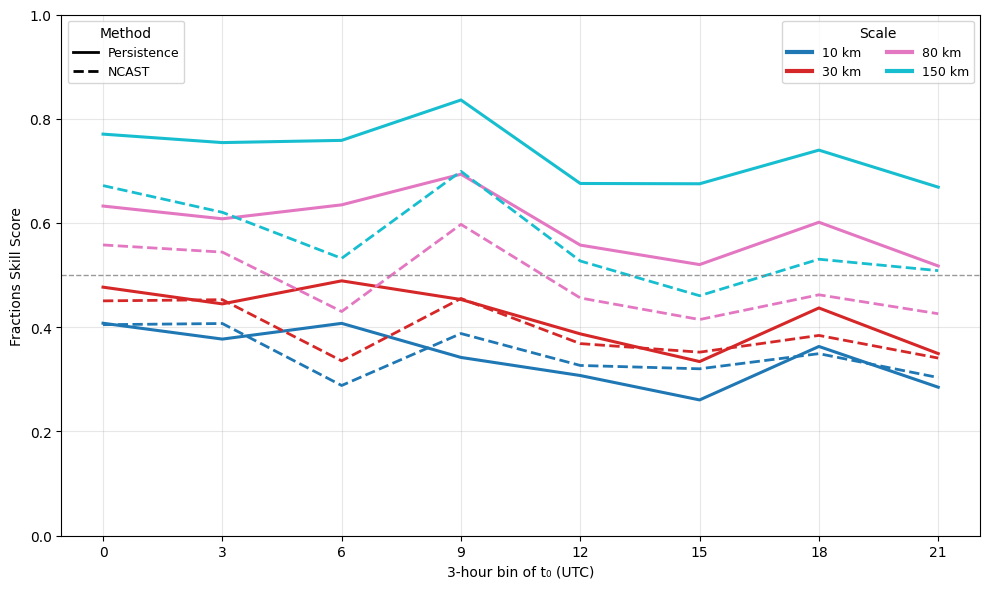

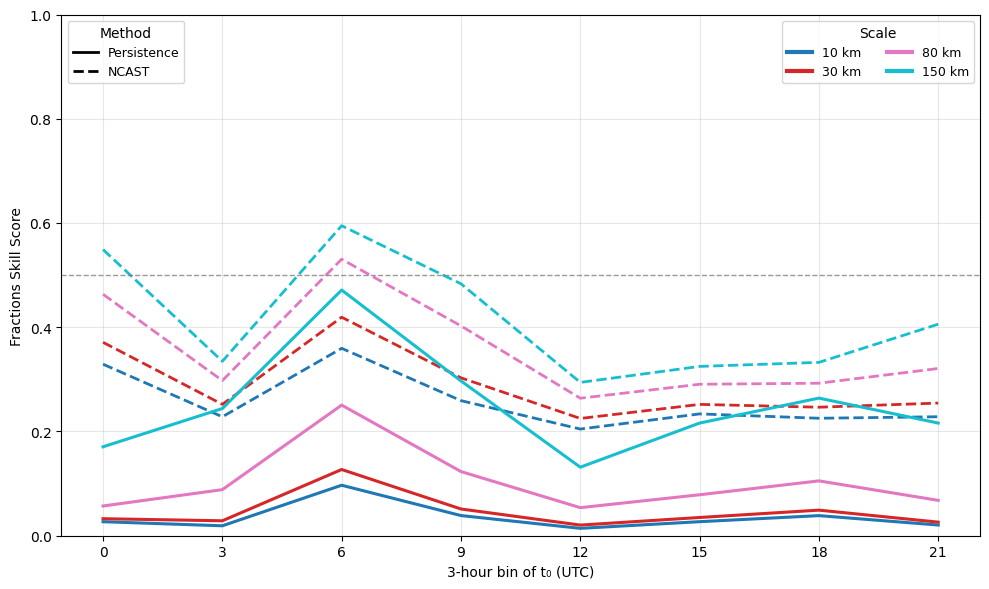

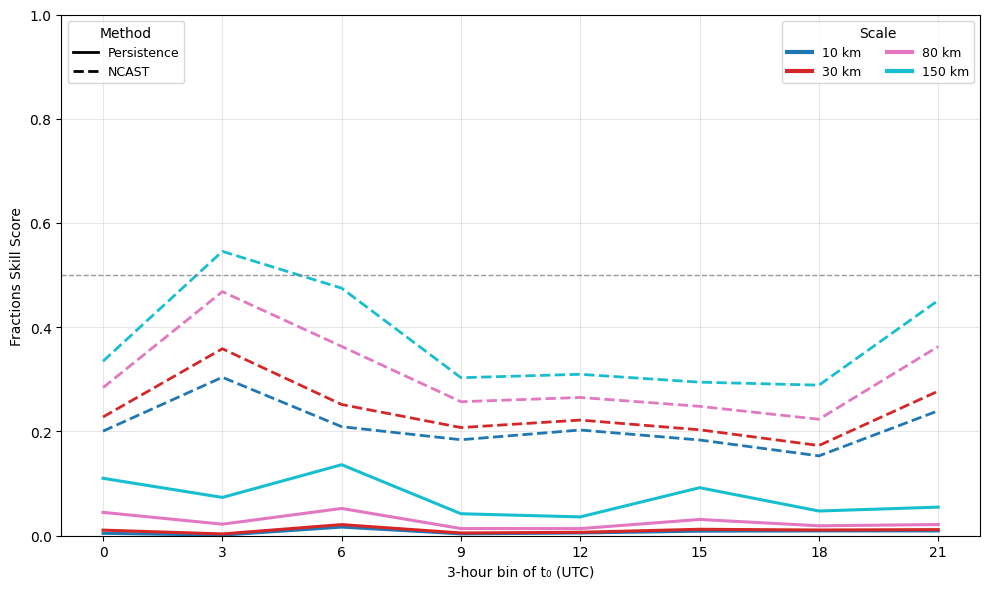

In [137]:
fss_path = "/work/scratch-nopw2/mendrika/OB/evaluation/ncast-nflics/fss/15"
pattern = r"fss_hour_(\d\d)_t(\d+)\.csv"

files = sorted(os.listdir(fss_path))
all_dfs = []

# load all CSVs and annotate
for fname in files:
    m = re.match(pattern, fname)
    if not m:
        continue

    hour = int(m.group(1))
    lt = int(m.group(2))

    df = pd.read_csv(os.path.join(fss_path, fname))
    df["hour"] = hour
    df["lead_time"] = lt

    # round scale to nearest 10 km
    if "scale_km" in df.columns:
        df["scale_km"] = (df["scale_km"] / 10).round() * 10

    # keep only <= 150 km
    df = df[df["scale_km"] <= 150]

    all_dfs.append(df)

if not all_dfs:
    raise RuntimeError("No FSS CSV files found. Check path or pattern.")

# combine everything
fss_all = pd.concat(all_dfs, ignore_index=True)

# create hour bins
fss_all["hour_bin"] = (fss_all["hour"] // 3) * 3

lead_times = sorted(fss_all["lead_time"].unique())

palette = plt.colormaps.get_cmap("tab10")

for lt in lead_times:
    df_lt = fss_all[fss_all["lead_time"] == lt]
    if df_lt.empty:
        print(f"No data for lead time t{lt}")
        continue

    # average within bins (ONLY model + persistence)
    df_mean = (
        df_lt.groupby(["hour_bin", "scale_km"], as_index=False)[["model", "persistence"]]
        .mean()
        .sort_values("hour_bin")
    )

    scales = sorted(df_mean["scale_km"].unique())
    n_scales = len(scales)
    colours = {s: palette(i / max(1, n_scales - 1)) for i, s in enumerate(scales)}

    plt.figure(figsize=(10, 6))

    # plot one line per scale
    for s in scales:
        df_s = df_mean[df_mean["scale_km"] == s]
        colour = colours[s]

        # Persistence – solid
        plt.plot(
            df_s["hour_bin"], df_s["persistence"],
            color=colour, linestyle="-", linewidth=2.2,
        )

        # Model – dashed
        plt.plot(
            df_s["hour_bin"], df_s["model"],
            color=colour, linestyle="--", linewidth=2.0,
        )

    plt.axhline(y=0.5, color="grey", linestyle="--", linewidth=1, alpha=0.8)

    plt.xlabel("3-hour bin of t₀ (UTC)")
    plt.ylabel("Fractions Skill Score")
    plt.xticks(range(0, 24, 3))
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3, linewidth=0.8)

    # legends
    scale_handles = [
        Line2D([], [], color=colours[s], linestyle="-", linewidth=3,
               label=f"{int(s)} km")
        for s in scales
    ]

    method_handles = [
        Line2D([], [], color="black", linestyle="-", linewidth=2, label="Persistence"),
        Line2D([], [], color="black", linestyle="--", linewidth=2, label="NCAST"),
    ]

    first_leg = plt.legend(
        handles=scale_handles,
        title="Scale",
        ncol=2,
        loc="upper right",
        fontsize=9,
    )
    plt.gca().add_artist(first_leg)

    plt.legend(
        handles=method_handles,
        title="Method",
        loc="upper left",
        fontsize=9,
    )

    plt.tight_layout()
    plt.show()


In [84]:
df_mean_all = (
    fss_all.groupby(["lead_time", "scale_km"], as_index=False)[["model", "persistence"]]
    .mean()
)

# pivot into 2D heatmap format
pivot_model = df_mean_all.pivot(index="scale_km", columns="lead_time", values="model")
pivot_pers  = df_mean_all.pivot(index="scale_km", columns="lead_time", values="persistence")

# sort scales descending (largest at top)
pivot_model = pivot_model.sort_index(ascending=False)
pivot_pers  = pivot_pers.sort_index(ascending=False)

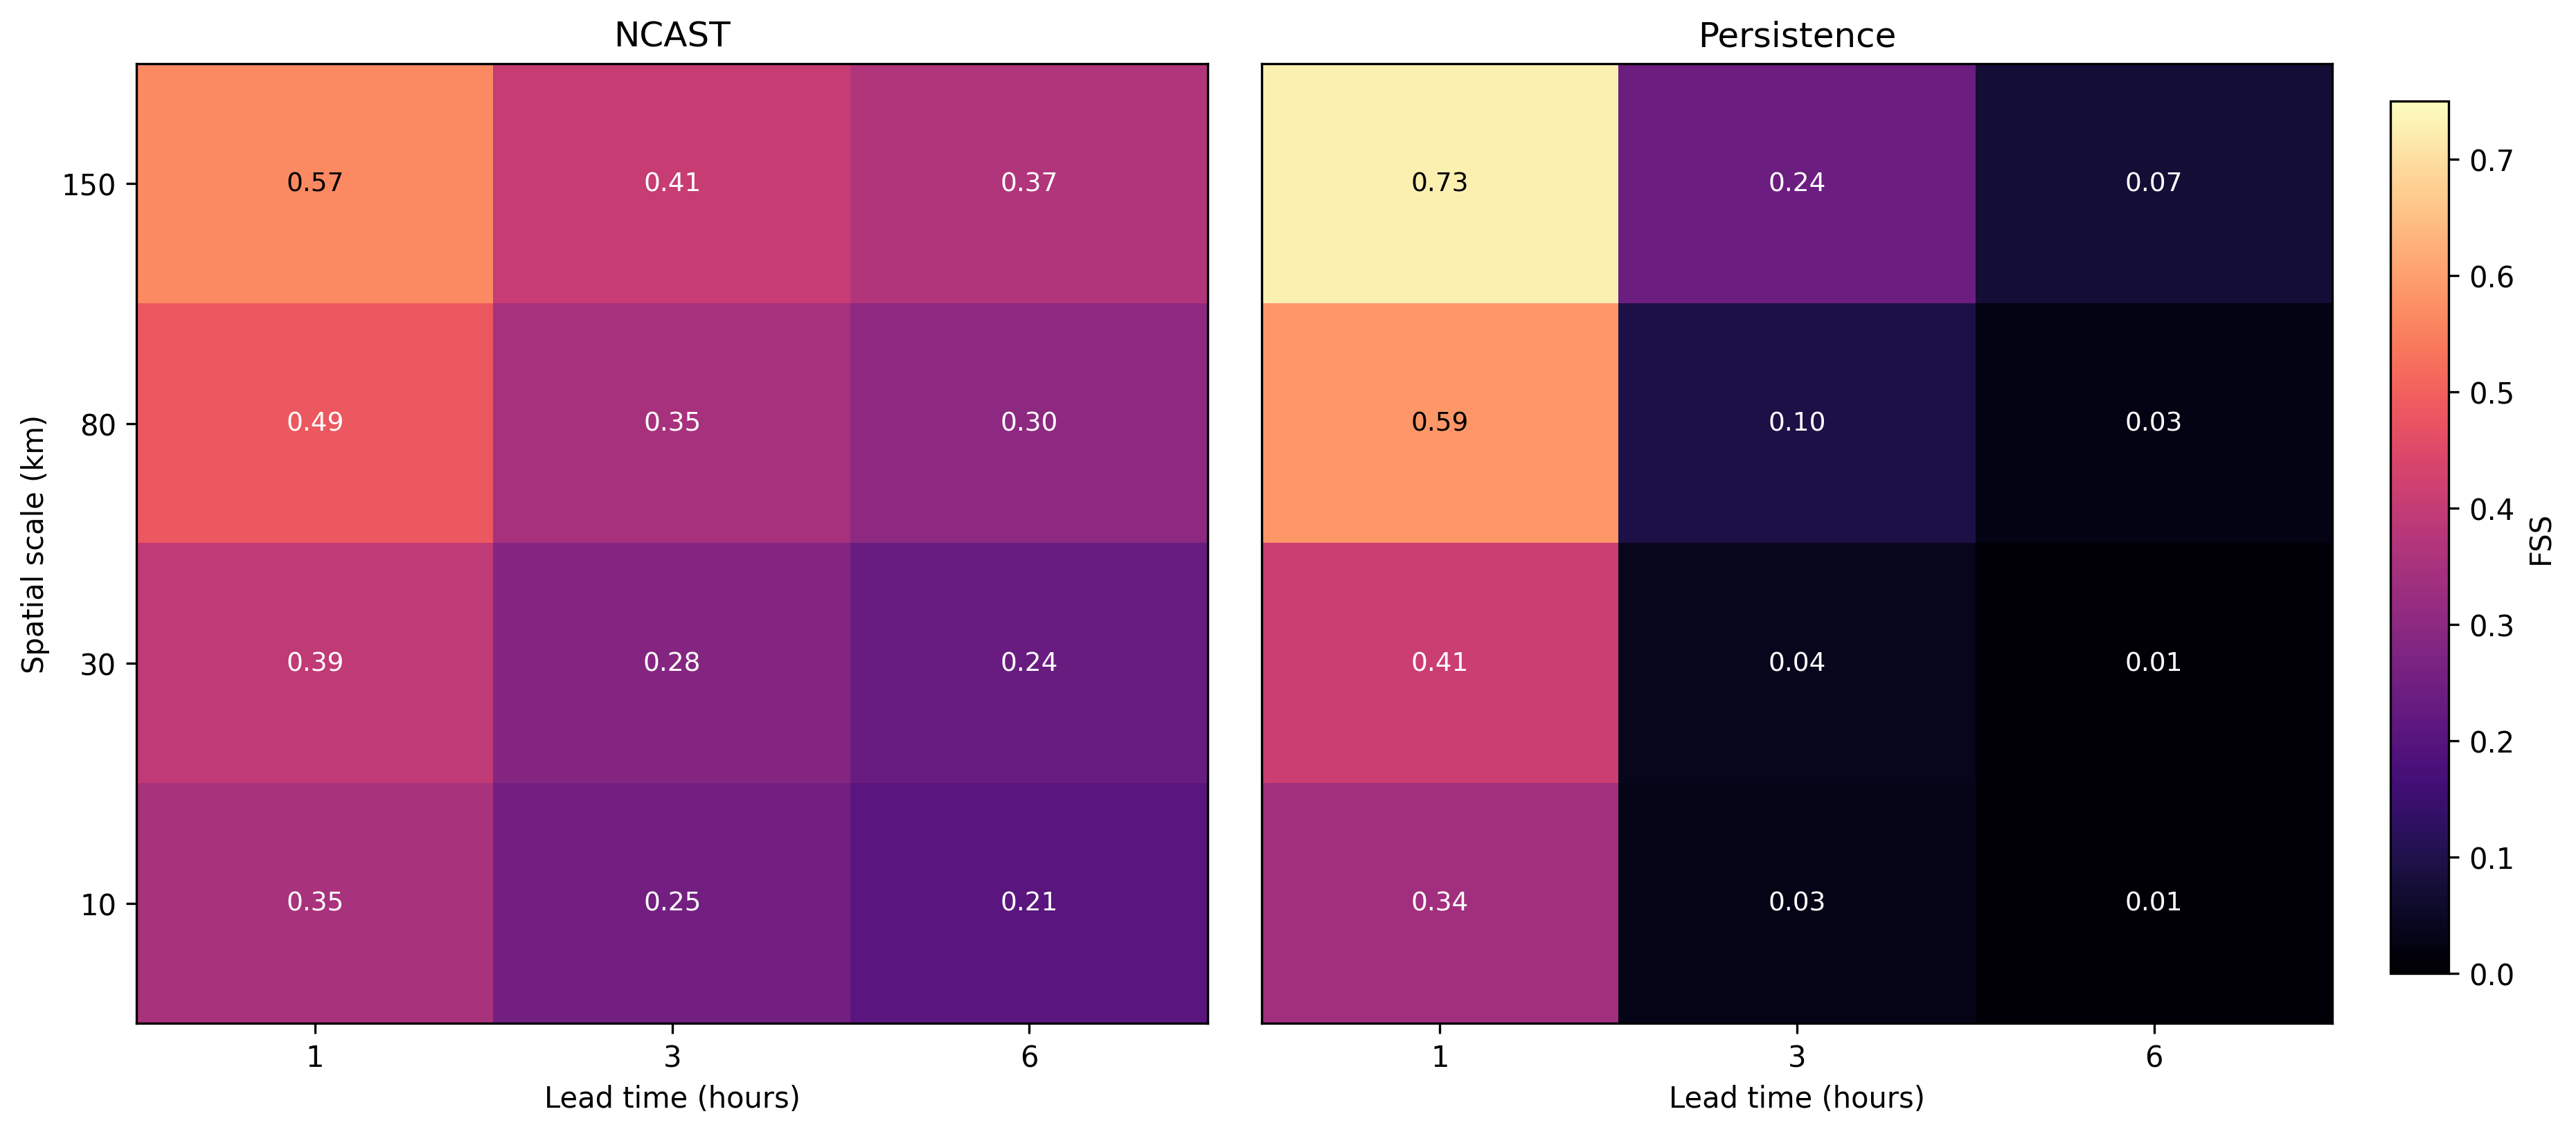

In [119]:
pivot_model.index = pivot_model.index.astype(int)
pivot_pers.index   = pivot_pers.index.astype(int)

cmap = "magma"

fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

def annotate_heatmap(ax, data):
    ny, nx = data.shape
    for i in range(ny):
        for j in range(nx):
            val = data[i, j]
            text = "" if np.isnan(val) else f"{val:.2f}"
            ax.text(
                j, i, text,
                ha="center", va="center",
                color="white" if val<0.5 else "black",
                fontsize=9
            )

im1 = ax[0].imshow(
    pivot_model, cmap=cmap, aspect="auto", vmin=0, vmax=0.75
)
ax[0].set_title("NCAST")

ax[0].set_xlabel("Lead time (hours)")
ax[0].set_xticks(range(len(pivot_model.columns)))
ax[0].set_xticklabels(pivot_model.columns)

ax[0].set_ylabel("Spatial scale (km)")
ax[0].set_yticks(range(len(pivot_model.index)))
ax[0].set_yticklabels(pivot_model.index)

annotate_heatmap(ax[0], pivot_model.values)

im2 = ax[1].imshow(
    pivot_pers, cmap=cmap, aspect="auto", vmin=0, vmax=0.75
)
ax[1].set_title("Persistence")

ax[1].set_xlabel("Lead time (hours)")
ax[1].set_xticks(range(len(pivot_pers.columns)))
ax[1].set_xticklabels(pivot_pers.columns)

ax[1].set_yticks([])

annotate_heatmap(ax[1], pivot_pers.values)

fig.subplots_adjust(wspace=0.05, right=0.88)

cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # left, bottom, width, height
cbar = fig.colorbar(im1, cax=cbar_ax, orientation="vertical")
cbar.set_label("FSS")

plt.show()


# Reliability diagram

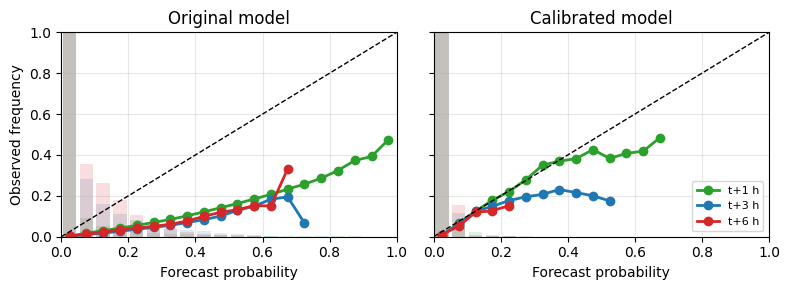

In [86]:
# reliability file paths
paths = {
    "t+1 h": "/work/scratch-nopw2/mendrika/OB/evaluation/ncast-calibrated/reliability/rel_t1.csv",
    "t+3 h": "/work/scratch-nopw2/mendrika/OB/evaluation/ncast-calibrated/reliability/rel_t3.csv",
    "t+6 h": "/work/scratch-nopw2/mendrika/OB/evaluation/ncast-calibrated/reliability/rel_t6.csv",
}

# colours
colours = {
    "t+1 h": "tab:green",
    "t+3 h": "tab:blue",
    "t+6 h": "tab:red",
}

MIN_SAMPLES = 50

# figure with two panels
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# panel titles
titles = ["Original model", "Calibrated model"]

# loop through both panels
for ax, mode in zip(axes, ["raw", "cal"]):

    # loop per lead time
    for label, path in paths.items():

        df = pd.read_csv(path)

        bin_centres = df["bin_centre"].values

        if mode == "raw":
            obs = df["obs_raw"].values
            counts = df["counts_raw"].values
        else:
            obs = df["obs_cal"].values
            counts = df["counts_cal"].values

        # sharpness scaling
        sharp = counts / counts.max() if counts.max() > 0 else counts

        # sharpness histogram
        ax.bar(
            bin_centres,
            sharp,
            width=0.04,
            alpha=0.15,
            color=colours[label],
        )

        # mask for bins with enough samples
        mask = counts >= MIN_SAMPLES

        ax.plot(
            bin_centres[mask],
            obs[mask],
            "o-",
            linewidth=2,
            color=colours[label],
            label=label,
        )

    # 1:1 line
    ax.plot([0, 1], [0, 1], "--", color="black", linewidth=1)

    # axes formatting
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Forecast probability")
    ax.set_title(titles[0] if mode == "raw" else titles[1])
    ax.grid(alpha=0.3)

# shared y-label
axes[0].set_ylabel("Observed frequency")

# legend
axes[1].legend(loc="lower right", fontsize=8)

plt.tight_layout()
plt.show()


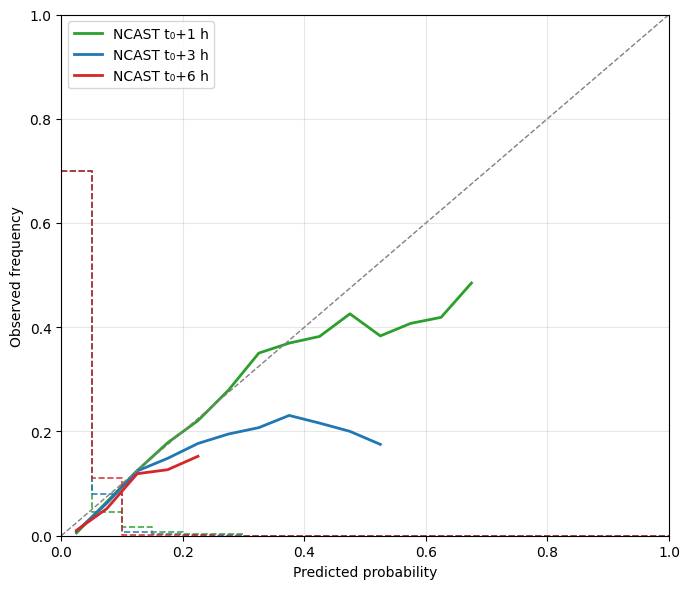

In [87]:
paths = {
    "NCAST t₀+1 h": "/work/scratch-nopw2/mendrika/OB/evaluation/ncast-calibrated/reliability/rel_t1.csv",
    "NCAST t₀+3 h": "/work/scratch-nopw2/mendrika/OB/evaluation/ncast-calibrated/reliability/rel_t3.csv",
    "NCAST t₀+6 h": "/work/scratch-nopw2/mendrika/OB/evaluation/ncast-calibrated/reliability/rel_t6.csv",
}

colours = {
    "NCAST t₀+1 h": "tab:green",
    "NCAST t₀+3 h": "tab:blue",
    "NCAST t₀+6 h": "tab:red",
}

MIN_SAMPLES = 100
SCALE = 0.7   # reduce histogram height

plt.figure(figsize=(7, 6))

for label, path in paths.items():

    df = pd.read_csv(path)

    bin_left   = df["bin_left"].values
    bin_right  = df["bin_right"].values
    bin_centres = df["bin_centre"].values
    obs = df["obs_cal"].values
    counts = df["counts_cal"].values

    edges = np.r_[bin_left, bin_right[-1]]

    sharp = counts / counts.max() if counts.max() > 0 else counts
    sharp_scaled = sharp * SCALE

    plt.step(
        edges,
        np.r_[sharp_scaled, sharp_scaled[-1]],
        where="post",
        linestyle="--",
        linewidth=1.2,
        color=colours[label],
        alpha=0.9,
    )

    mask = counts >= MIN_SAMPLES

    plt.plot(
        bin_centres[mask],
        obs[mask],
        "-",
        linewidth=2,
        color=colours[label],
        label=label,
    )

plt.plot([0, 1], [0, 1], "--", color="grey", linewidth=1)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Full AUC

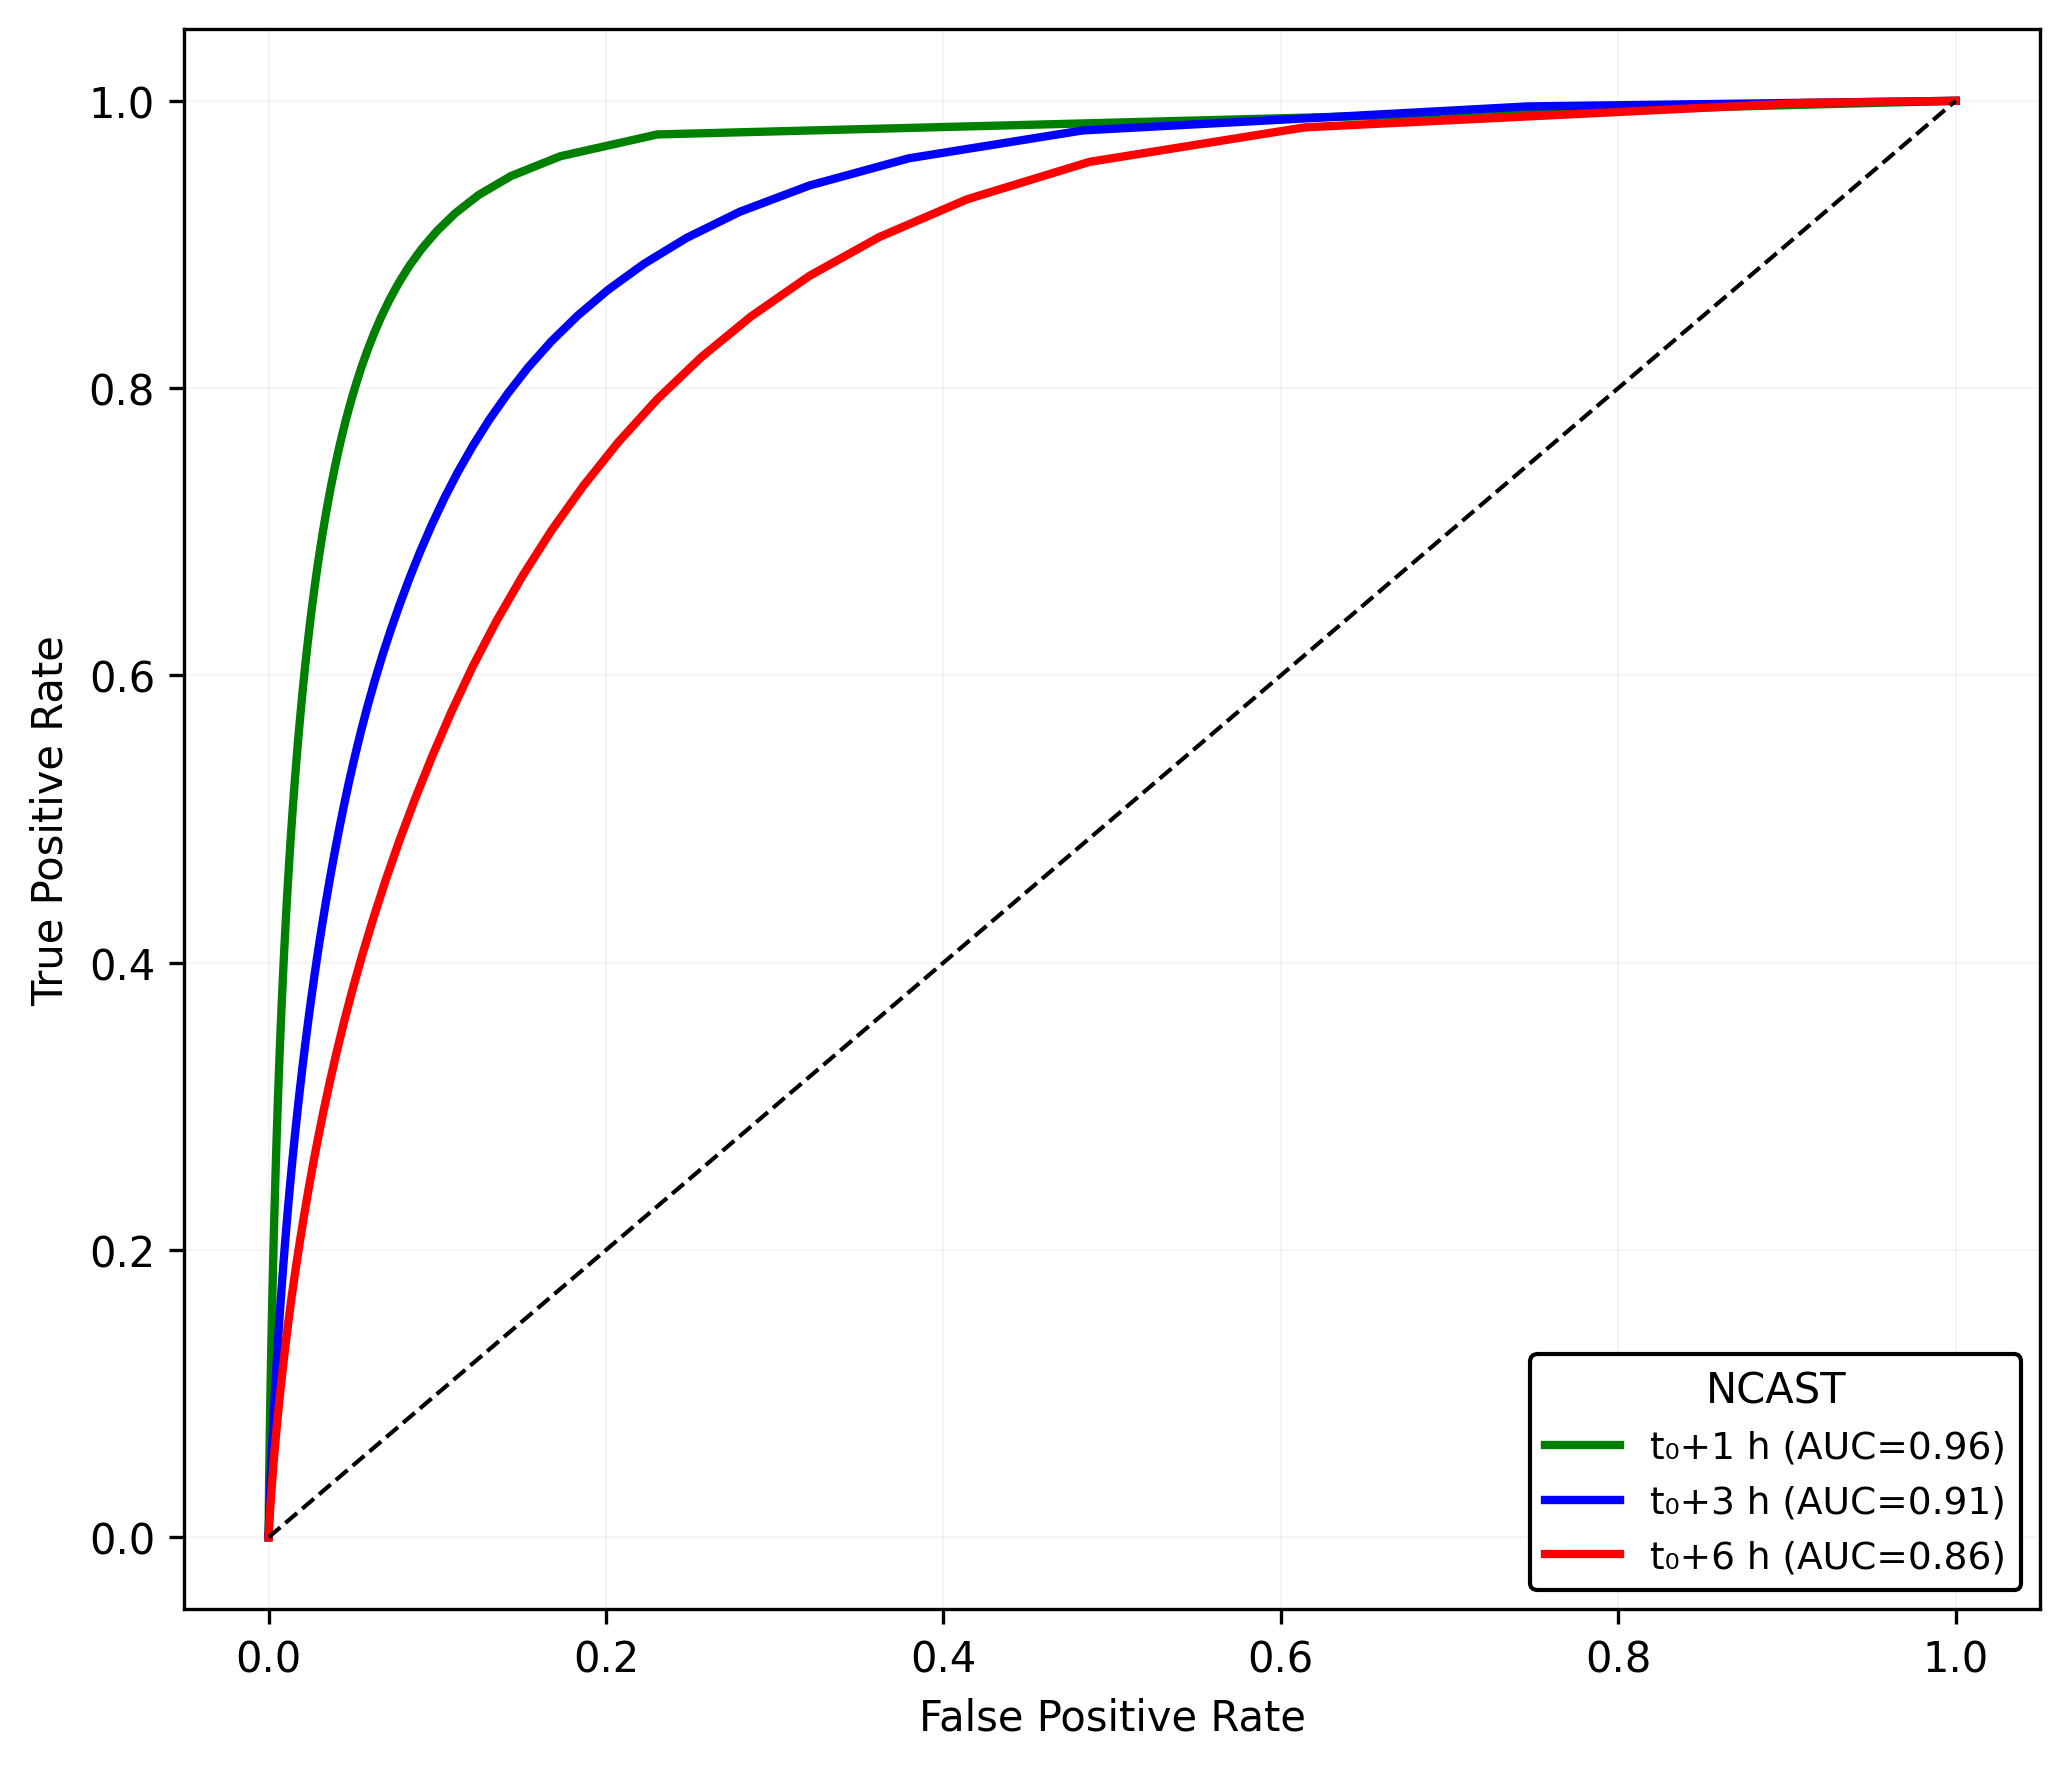

In [135]:
roc_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/ncast-calibrated/roc"

lead_times = ["1", "3", "6"]

colours = {
    "1": "green",
    "3": "blue",
    "6": "red",
}

plt.figure(figsize=(7, 6), dpi=300)

for lt in lead_times:

    thresholds = np.load(os.path.join(roc_dir, f"roc_thresholds_t{lt}.npy"))
    fpr_m = np.load(os.path.join(roc_dir, f"roc_fpr_model_t{lt}.npy"))
    tpr_m = np.load(os.path.join(roc_dir, f"roc_tpr_model_t{lt}.npy"))

    auc_model = auc(fpr_m, tpr_m)

    plt.plot(
        fpr_m,
        tpr_m,
        color=colours[lt],
        linewidth=2.0,
        label=f"t₀+{lt} h (AUC={auc_model:.2f})"
    )

plt.plot([0, 1], [0, 1], color="black", linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, linewidth=0.1, alpha=0.6)

plt.legend(
    title="NCAST",
    loc="lower right",
    frameon=True,
    framealpha=1.0,
    edgecolor="black",
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.show()
